In [1]:
import cobra
import pandas as pd
import modelseedpy

modelseedpy 0.4.0


In [2]:
model_rhoda = cobra.io.load_json_model('./data/model_rhoda_gf2.json')
model_acido = cobra.io.load_json_model('./data/model_acido_gf2.json')

Set parameter TSPort to value 27070
Set parameter TokenServer to value "lic-vmw-01.cels.anl.gov"


In [4]:
MEDIA_ACETATE_NITRATE = {
    'EX_cpd00067_e0': 100.0,
    'EX_cpd00058_e0': 100.0,
    'EX_cpd00971_e0': 34.9324073,
    'EX_cpd00013_e0': 100.0,
    'EX_cpd00205_e0': 1.3415688,
    'EX_cpd00009_e0': 100.0,
    'EX_cpd11574_e0': 100.0,
    'EX_cpd00048_e0': 100.0,
    'EX_cpd00030_e0': 100.0,
    'EX_cpd00209_e0': 10.0,
    'EX_cpd00254_e0': 100.0,
    'EX_cpd10515_e0': 100.0,
    'EX_cpd00149_e0': 100.0,
    'EX_cpd00099_e0': 100.0,
    'EX_cpd00001_e0': 100.0,
    'EX_cpd00029_e0': 20.0,
    'EX_cpd00063_e0': 100.0,
    'EX_cpd00034_e0': 100.0,
    'EX_cpd00305_e0': 100.0
}

In [5]:
model_rhoda.medium = MEDIA_ACETATE_NITRATE
model_acido.medium = MEDIA_ACETATE_NITRATE

In [6]:
model_acido.reactions.rxn10126_c0.upper_bound = 0
model_rhoda.reactions.rxn10126_c0.upper_bound = 0

In [7]:
df_growth_data_r12 = pd.read_csv('./data/growth_data_R12.tsv', sep='\t')
df_growth_data_3h11 = pd.read_csv('./data/growth_data_3H11.tsv', sep='\t')

In [29]:
exp_data_3h11 = {
    'time_total': 71,
    'ac_uptake': -1.7762543,
    'growth_OD': 0.07776,
    'OD_coeff': 0.006,
    'no3_uptake': -9.00923926
}
exp_data_r12 = {
    'time_total': 336,
    'ac_uptake': -5.4139872,
    'growth_OD': 0.40074,
    'OD_coeff': 0.008,
    'no3_uptake': -9.03407482
}

In [9]:
_od_to_biomass_coeff = exp_data_r12['OD_coeff']
_model = model_rhoda
_data = df_growth_data_r12.to_dict()

In [12]:
len(df_growth_data_r12), len(_data)

(11, 6)

In [17]:
len(_data['time'])

11

In [24]:
model_rhoda.reactions.EX_cpd00528_e0.upper_bound = 0

In [30]:
_od_to_biomass_coeff = exp_data_3h11['OD_coeff']
_model = model_acido
_data = df_growth_data_3h11.to_dict()

In [31]:
solutions_bio = []
solutions_atp = {}

for i in range(len(_data['time']) - 1):
    print(i, i+1)
    _t0 = _data['time'][i]
    _t1 = _data['time'][i + 1]
    _t = _t1 - _t0
    _ac0 = _data['Acetate'][i]
    _ac1 = _data['Acetate'][i + 1]
    
    _od600_0 = _data['OD600'][i]
    _od600_1 = _data['OD600'][i + 1]
    
    _no3_0 = _data['NO3'][i]
    _no3_1 = _data['NO3'][i + 1]
    
    _ac_uptake = (_ac1 - _ac0) / _t
    _no3_uptake = (_no3_1 - _no3_0) / _t
    _od600_change = (_od600_1 - _od600_0) / _t
    _biomass_change = _od600_change * _od_to_biomass_coeff
    
    if _ac_uptake < 0 and _no3_uptake < 0:
    
        print(_t0, _t1)
        print(_ac0, _ac1, _ac_uptake)
        print(_no3_0, _no3_1, _no3_uptake)
        print(_od600_0, _od600_1, _od600_change, _biomass_change)
        
        _model.objective = 'bio1'
        _model.reactions.EX_cpd00209_e0.lower_bound = _no3_uptake
        _model.reactions.EX_cpd00029_e0.lower_bound = _ac_uptake
        _model.reactions.bio1.lower_bound = 0
        _model.reactions.bio1.upper_bound = _biomass_change

        sol_bio = cobra.flux_analysis.pfba(_model)
        solutions_bio.append(sol_bio)

        _biomass_err = (_biomass_change - sol_bio.fluxes['bio1']) ** 2
        _ac_err = (_ac_uptake - sol_bio.fluxes['EX_cpd00029_e0']) ** 2
        _no3_err = (_no3_uptake - sol_bio.fluxes['EX_cpd00209_e0']) ** 2
        

        print('error biomass:', _biomass_err, 'AC', _ac_err, 'NO3', _no3_err)
        
        _model.objective = 'ATPM_c0'
        _model.reactions.bio1.lower_bound = _biomass_change
        _model.reactions.bio1.upper_bound = _biomass_change
        
        sol_atp = cobra.flux_analysis.pfba(_model)
        solutions_atp[(_t0, _t1)] = sol_atp
        
        _biomass_err = (_biomass_change - sol_atp.fluxes['bio1']) ** 2
        _ac_err = (_ac_uptake - sol_atp.fluxes['EX_cpd00029_e0']) ** 2
        _no3_err = (_no3_uptake - sol_atp.fluxes['EX_cpd00209_e0']) ** 2
        

        print('error biomass:', _biomass_err, 'AC', _ac_err, 'NO3', _no3_err)
        print(sol_atp.fluxes['ATPM_c0'])
        print()

0 1
0 23
18.0313603 17.8153092 -0.009393526086956427
9.14450462 7.89058453 -0.05451826478260867
0.01013 0.03307 0.0009973913043478263 5.984347826086957e-06
error biomass: 0.0 AC 8.377585549782597e-05 NO3 0.00291744891778715
error biomass: 0.0 AC 4.286198126811034e-18 NO3 0.0003028414818080274
0.04233109075028085

1 2
23 42
17.8153092 16.0726961 -0.09171647894736841
7.89058453 1.35000045 -0.3442412673684211
0.03307 0.06107 0.0014736842105263156 8.842105263157893e-06
error biomass: 0.0 AC 0.008346812251707709 NO3 0.11798896756119623
error biomass: 0.0 AC 3.009022641733296e-05 NO3 0.0
0.39716200220923764

2 3
42 53
16.0726961 15.9261701 -0.01332054545454559
1.35000045 0.12091592 -0.11173495727272727
0.06107 0.07075 0.0008799999999999995 5.279999999999997e-06
error biomass: 0.0 AC 0.000171826323308037 NO3 0.012385358775833365
error biomass: 0.0 AC 8.3415402669387935e-19 NO3 0.0034640789795323287
0.06062553509350305

3 4
4 5


In [32]:
def generate_total_acc_data(solutions, capture, base_values=None):
    if base_values is None:
        base_values = {}
    df_res = {k: [] for k in capture}
    df_res['time'] = []
    arr_acc = {k: base_values.get(k, 0) for k in capture}
    
    for (_t0, _t1), sol in solutions.items():
        time = _t0
        _t = _t1 - _t0
        for time_step in range(_t):
            for alias, rxn_id in capture.items():
                df_res[alias].append(arr_acc[alias])
                arr_acc[alias] += sol.fluxes[rxn_id]
            df_res['time'].append(time)
            time += 1
    
    return df_res
capture = {
    'biomass': 'bio1',
    'acetate': 'EX_cpd00029_e0',
    'no3': 'EX_cpd00209_e0',
    'no2': 'EX_cpd00075_e0',
    'n2o': 'EX_cpd00659_e0',
    'no': 'EX_cpd00418_e0',
    'n2': 'EX_cpd00528_e0',
}
base_values = {
    'biomass': 0.01093 * _od_to_biomass_coeff,
    'acetate': 18.0313603,
    'no3': 9.14450462,
}
_data_pred = generate_total_acc_data(solutions_atp, capture, base_values)
_data_exp = {k: list(v.values()) for k, v in _data.items()}
_data_exp['biomass'] = [x * _od_to_biomass_coeff for x in _data_exp['OD600']]
_data_exp.keys()

dict_keys(['time', 'Acetate', 'OD600', 'NO3', 'NO2', 'N2O', 'biomass'])

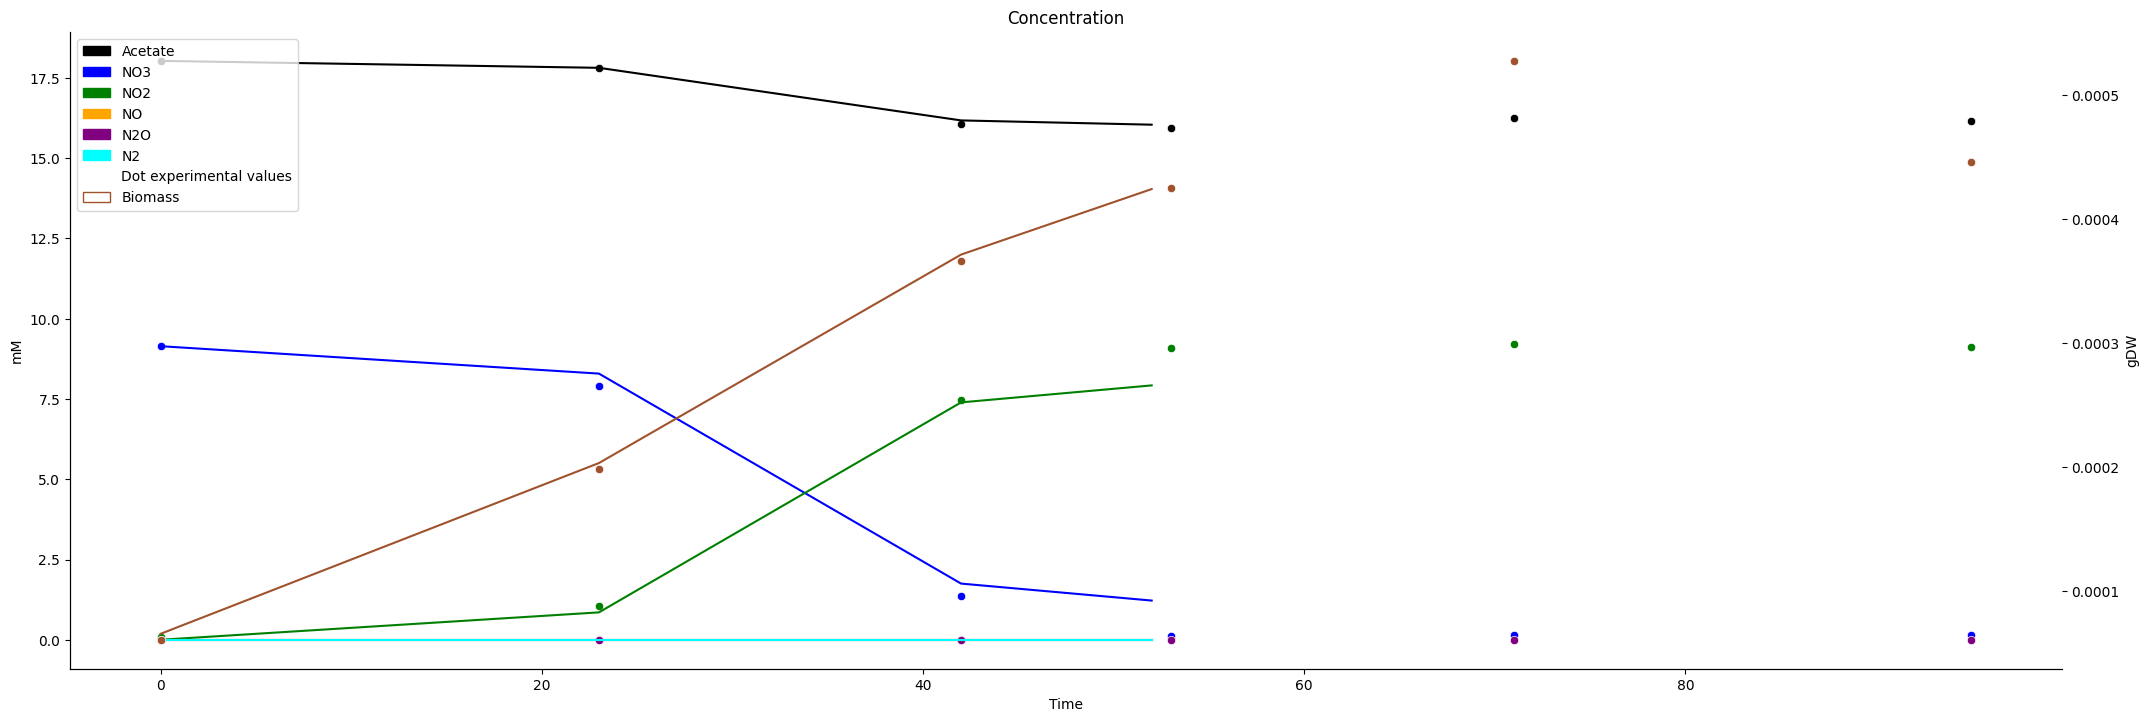

In [33]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

color_acetate = 'black'
color_no3 = 'blue'
color_no2 = 'green'
color_n2o = 'purple'
color_no = 'orange'
color_n2 = 'cyan'

fig, ax = plt.subplots()
ax2 = ax.twinx()
fig.set_size_inches(25.7, 8.27)


sns.lineplot(data=_data_pred, x='time', y='biomass', ax=ax2, color='sienna')
sns.scatterplot(data=_data_exp, x='time', y='biomass', ax=ax2, color='sienna')

sns.lineplot(data=_data_pred, x='time', y='acetate', ax=ax, color=color_acetate)
sns.scatterplot(data=_data_exp, x='time', y='Acetate', ax=ax, color=color_acetate)
sns.lineplot(data=_data_pred, x='time', y='no3', ax=ax, color=color_no3)
sns.scatterplot(data=_data_exp, x='time', y='NO3', ax=ax, color=color_no3)
sns.lineplot(data=_data_pred, x='time', y='no2', ax=ax, color=color_no2)
sns.scatterplot(data=_data_exp, x='time', y='NO2', ax=ax, color=color_no2)
sns.lineplot(data=_data_pred, x='time', y='n2o', ax=ax, color=color_n2o)
sns.scatterplot(data=_data_exp, x='time', y='N2O', ax=ax, color=color_n2o)

sns.lineplot(data=_data_pred, x='time', y='no', ax=ax, color=color_no)
sns.lineplot(data=_data_pred, x='time', y='n2', ax=ax, color=color_n2)

plt.legend(handles=[
    mpatches.Patch(color=color_acetate, label='Acetate'),
    mpatches.Patch(color=color_no3, label='NO3'),
    mpatches.Patch(color=color_no2, label='NO2'),
    mpatches.Patch(color=color_no, label='NO'),
    mpatches.Patch(color=color_n2o, label='N2O'),
    mpatches.Patch(color=color_n2, label='N2'),
    mpatches.Patch(label='Dot experimental values', facecolor=None, color='white'),
    mpatches.Patch(edgecolor='sienna', label='Biomass', facecolor='white'),
        ])
ax.set_title('Concentration')
ax.set_xlabel('Time')
ax.set_ylabel('mM')
ax2.set_ylabel('gDW')
sns.despine(fig, ax)



In [139]:
_data_plot['N2O']

[0.0,
 0.01533133,
 0.00761067,
 0.31666667,
 0.53458002,
 1.81498113,
 3.74049231,
 4.16233813,
 4.30058155,
 4.2472569,
 4.10212792]

In [142]:
_model.summary(sol_atp)

Metabolite,Reaction,Flux,C-Number,C-Flux
cpd00009_e0,EX_cpd00009_e0,1.546E-06,0,0.00%
cpd00013_e0,EX_cpd00013_e0,2.189E-05,0,0.00%
cpd00029_e0,EX_cpd00029_e0,0.009082,2,100.00%
cpd00048_e0,EX_cpd00048_e0,5.83E-07,0,0.00%
cpd00067_e0,EX_cpd00067_e0,0.02352,0,0.00%
cpd00209_e0,EX_cpd00209_e0,0.01446,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
cpd00001_e0,EX_cpd00001_e0,-0.02536,0,0.00%
cpd00011_e0,EX_cpd00011_e0,-0.01808,1,100.00%
cpd00528_e0,EX_cpd00528_e0,-0.00723,0,0.00%


In [45]:
sol.fluxes['EX_cpd00029_e0']

-7.689419874397695e-05

In [24]:
df_growth_data_r12

,time,Acetate,OD600,NO3,NO2,N2O
0,0,18.031360,0.010930,9.144505,0.099779,0.000000
1,23,17.790639,0.015870,8.967896,0.156697,0.015331
2,42,18.427579,0.020300,9.531939,0.079565,0.007611
3,71,18.258625,0.044930,8.649449,0.107758,0.316667
4,77,18.537473,0.062467,8.662695,0.094460,0.534580
5,95,17.321905,0.106167,7.075978,0.126908,1.814981
6,119,16.723092,0.171890,5.450628,0.139143,3.740492
7,142,16.008404,0.223500,4.374420,0.126908,4.162338
8,165,15.139714,0.289167,3.323048,0.124781,4.300582
9,216,14.235140,0.368300,1.845608,0.094460,4.247257
